# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


Using TensorFlow backend.


We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 64 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
sample_image = os.listdir('./Project_data/train'+'/'+ np.random.permutation(train_doc)[0 + (0)].split(';')[0])

In [5]:
print(sample_image)

['WIN_20180926_17_24_58_Pro_00051.png', 'WIN_20180926_17_24_58_Pro_00011.png', 'WIN_20180926_17_24_58_Pro_00021.png', 'WIN_20180926_17_24_58_Pro_00035.png', 'WIN_20180926_17_24_58_Pro_00031.png', 'WIN_20180926_17_24_58_Pro_00053.png', 'WIN_20180926_17_24_58_Pro_00055.png', 'WIN_20180926_17_24_58_Pro_00015.png', 'WIN_20180926_17_24_58_Pro_00029.png', 'WIN_20180926_17_24_58_Pro_00009.png', 'WIN_20180926_17_24_58_Pro_00065.png', 'WIN_20180926_17_24_58_Pro_00023.png', 'WIN_20180926_17_24_58_Pro_00039.png', 'WIN_20180926_17_24_58_Pro_00057.png', 'WIN_20180926_17_24_58_Pro_00007.png', 'WIN_20180926_17_24_58_Pro_00045.png', 'WIN_20180926_17_24_58_Pro_00037.png', 'WIN_20180926_17_24_58_Pro_00017.png', 'WIN_20180926_17_24_58_Pro_00047.png', 'WIN_20180926_17_24_58_Pro_00063.png', 'WIN_20180926_17_24_58_Pro_00027.png', 'WIN_20180926_17_24_58_Pro_00049.png', 'WIN_20180926_17_24_58_Pro_00043.png', 'WIN_20180926_17_24_58_Pro_00061.png', 'WIN_20180926_17_24_58_Pro_00059.png', 'WIN_20180926_17_24_58_P

In [6]:
sample_im_path = './Project_data/train'+'/'+ train_doc[0].split(';')[0]
sample = imread(sample_im_path+'/'+os.listdir(sample_im_path)[0])

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

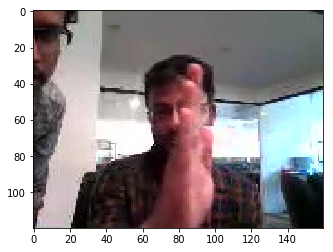

In [8]:
plt.imshow(sample)

In [9]:
sample.shape

(120, 160, 3)

In [10]:
sample = imresize(sample,(50,50))

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


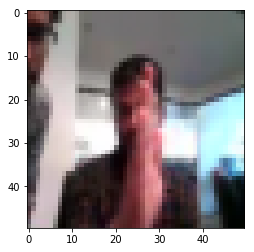

In [11]:
plt.imshow(sample)

In [12]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.arange(0,30,3) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),50,50,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = imresize(image,(50,50))
                    image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        rem_image = len(folder_list)%batch_size
        batch += 1
        if(rem_image!=0):
            batch_data = np.zeros((rem_image,len(img_idx),50,50,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((rem_image,5)) # batch_labels is the one hot representation of the output
            for folder in range(rem_image): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                   
                    image = imresize(image,(50,50))
                    image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels
            
       


In [13]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)
num_classes = 5

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [14]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (2, 2), padding='same'),
                 input_shape=(10,50,50,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(16, (2, 2))))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(256, return_sequences=False, dropout=0.5))
model.add(Dense(64,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
 

In [15]:


# compile it
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['categorical_accuracy'])

# summary of model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 50, 50, 16)    208       
_________________________________________________________________
activation_1 (Activation)    (None, 10, 50, 50, 16)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 50, 50, 16)    64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 49, 49, 16)    1040      
_________________________________________________________________
activation_2 (Activation)    (None, 10, 49, 49, 16)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 49, 49, 16)    64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 24, 24, 16)    0         
__________

In [16]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [17]:
# model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
model_name = 'model' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#LR = # write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.01)
callbacks_list = [checkpoint]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [18]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [19]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/valSource path =  ./Project_data/train ; batch size =Epoch 1/50
 ; batch size = 64
 64


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


11/11 [==============================] - 102s 9s/step - loss: 2.7695 - categorical_accuracy: 0.1892 - val_loss: 2.5983 - val_categorical_accuracy: 0.2900

Epoch 00001: saving model to model_2019-03-1702_59_45.365610/model-00001-2.76507-0.19005-2.59834-0.29000.h5
Epoch 2/50
11/11 [==============================] - 25s 2s/step - loss: 2.6543 - categorical_accuracy: 0.2495 - val_loss: 2.5347 - val_categorical_accuracy: 0.4000

Epoch 00002: saving model to model_2019-03-1702_59_45.365610/model-00002-2.65333-0.24887-2.53469-0.40000.h5
Epoch 3/50
11/11 [==============================] - 25s 2s/step - loss: 2.6229 - categorical_accuracy: 0.2497 - val_loss: 2.4778 - val_categorical_accuracy: 0.4000

Epoch 00003: saving model to model_2019-03-1702_59_45.365610/model-00003-2.61887-0.25641-2.47783-0.40000.h5
Epoch 4/50
11/11 [==============================] - 25s 2s/step - loss: 2.5513 - categorical_accuracy: 0.3150 - val_loss: 2.4120 - val_categorical_accuracy: 0.4700

Epoch 00004: saving model 

11/11 [==============================] - 26s 2s/step - loss: 1.6501 - categorical_accuracy: 0.6986 - val_loss: 1.8230 - val_categorical_accuracy: 0.6300

Epoch 00031: saving model to model_2019-03-1702_59_45.365610/model-00031-1.65364-0.69382-1.82303-0.63000.h5
Epoch 32/50
11/11 [==============================] - 26s 2s/step - loss: 1.6339 - categorical_accuracy: 0.7187 - val_loss: 1.7581 - val_categorical_accuracy: 0.6400

Epoch 00032: saving model to model_2019-03-1702_59_45.365610/model-00032-1.62978-0.72247-1.75812-0.64000.h5
Epoch 33/50
11/11 [==============================] - 25s 2s/step - loss: 1.6263 - categorical_accuracy: 0.7105 - val_loss: 1.8763 - val_categorical_accuracy: 0.6000

Epoch 00033: saving model to model_2019-03-1702_59_45.365610/model-00033-1.62893-0.70890-1.87634-0.60000.h5
Epoch 34/50
11/11 [==============================] - 25s 2s/step - loss: 1.5973 - categorical_accuracy: 0.7528 - val_loss: 2.1702 - val_categorical_accuracy: 0.5500

Epoch 00034: saving mode